# Network Traffic AutoTSEstimator (customized model)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demonstrate how to use **AutoTSEstimator** to adjust the parameters of a customized model.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper Function

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [14]:
import matplotlib.pyplot as plt
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16, 6))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Prepare Dataset

We use `get_public_tsdata` to load and process the data, specify the name and path, and the ts data set will be returned. Currently we support `nyc_taxi`, `network_traffic`, `fsi`, `AIOps`.

In [1]:
from sklearn.preprocessing import StandardScaler
from bigdl.chronos.data.repo_dataset import get_public_dataset

In [2]:
name = 'network_traffic'

stand = StandardScaler()
tsdata_train, tsdata_val, \
    tsdata_test = get_public_dataset(name,
                                     with_split=True,
                                     val_ratio=0.1,
                                     test_ratio=0.1)
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.impute('last')\
          .scale(stand, fit=tsdata is tsdata_train)


## Custom Model

Regarding the model, we use torch.nn.GRU to define, More details, please refer to [here](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU).

```python
# The input and output data should be reshaped to a 3d numpy array with the format of (batchsize, seq_len, feature_num).
out = out.view(out.shape[0], 1, out.shape[-1])
```
 Detailed information please refer to [here](https://bigdl.readthedocs.io/en/latest/doc/Chronos/Overview/data_processing_feature_engineering.html#roll-sampling).

In [3]:
import torch
from torch import nn
class GRUNet(nn.Module):
    def __init__(self, input_dim, layer_num, hidden_dim, dropout, output_dim):
        super(GRUNet, self).__init__()
        self.layer_num = layer_num
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_num, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_seq):
        h0 = torch.randn(self.layer_num, input_seq.size(0), self.hidden_dim)
        gru_out, _ = self.gru(input_seq, h0)
        out = self.fc(gru_out[:, -1, :])
        out = out.view(out.shape[0], 1, out.shape[-1])
        return out

Define a model creator function which returns the defined model.

In [4]:
def model_creator(config):
    return GRUNet(input_dim=config['input_feature_num'],
                  layer_num=config['layer_num'],
                  hidden_dim=config['hidden_dim'],
                  dropout=config['dropout'],
                  output_dim=config['output_feature_num'])

In [5]:
from bigdl.orca import init_orca_context
init_orca_context(cores=4, memory='10g', init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /home/liangs/spark/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/liangs/BigDL/dist/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/home/liangs/BigDL/dist/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2022-01-10 22:11:27,183	INFO services.py:1340 -- View the Ray dashboard at http://10.239.44.108:8265


{'node_ip_address': '10.239.44.108', 'raylet_ip_address': '10.239.44.108', 'redis_address': '10.239.44.108:6379', 'object_store_address': '/tmp/ray/session_2022-01-10_22-11-24_778075_18140/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-01-10_22-11-24_778075_18140/sockets/raylet', 'webui_url': '10.239.44.108:8265', 'session_dir': '/tmp/ray/session_2022-01-10_22-11-24_778075_18140', 'metrics_export_port': 52330, 'node_id': '678513955776bf86b3172c4c00e36db93813ca31117f649cd5a994b3'}


<SparkContext master=local[4] appName=pyspark-shell>

## Search space & Initialize `AutoTSEstimator`

Define the search interval of the parameter.

In [6]:
from bigdl.orca.automl import hp
search_space={
    'hidden_dim': hp.grid_search([32, 64]),
    'layer_num': hp.grid_search([2, 4]),
    'dropout': hp.uniform(0.1, 0.2)
}

Pass the defined search space and model to `AutoTSEstimator`.

In [7]:
from bigdl.chronos.autots.autotsestimator import AutoTSEstimator
autotsest = AutoTSEstimator(model=model_creator,
                            search_space=search_space,
                            past_seq_len=15,
                            metric='mse',
                            loss=torch.nn.MSELoss(),
                            cpus_per_trial=2)

## Fit Model & Evaluate

In [8]:
%%time
ts_pipeline = autotsest.fit(data=tsdata_train,
                            epochs=5,
                            batch_size=hp.choice([32, 64]),
                            validation_data=tsdata_val)

2022-01-10 22:11:28,579	WARNING function_runner.py:562 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
(bundle_reservation_check_func pid=18469) 
(bundle_reservation_check_func pid=18469) User settings:
(bundle_reservation_check_func pid=18469) 
(bundle_reservation_check_func pid=18469)    KMP_AFFINITY=granularity=fine,compact,1,0
(bundle_reservation_check_func pid=18469)    KMP_BLOCKTIME=0
(bundle_reservation_check_func pid=18469)    KMP_DUPLICATE_LIB_OK=True
(bundle_reservation_check_func pid=18469)    KMP_INIT_AT_FORK=FALSE
(bundle_reservation_check_func pid=18469)    KMP_SETTINGS=1
(bundle_reservation_check_func pid=18469)    OMP_NUM_THREADS=1
(bundle_reservation_check_func pid=18469) 
(bundle_reservation_check_func pid=18469) Effective settings:
(bundle_reservation_check_func pid=18469) 
(bundle_reservation_ch

Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num
train_func_34220_00000,RUNNING,10.239.44.108:18469,64,0.114795,32,2
train_func_34220_00001,PENDING,,64,0.174854,64,2
train_func_34220_00002,PENDING,,32,0.119272,32,4
train_func_34220_00003,PENDING,,64,0.123372,64,4


(bundle_reservation_check_func pid=18471) 
(bundle_reservation_check_func pid=18471) User settings:
(bundle_reservation_check_func pid=18471) 
(bundle_reservation_check_func pid=18471)    KMP_AFFINITY=granularity=fine,compact,1,0
(bundle_reservation_check_func pid=18471)    KMP_BLOCKTIME=0
(bundle_reservation_check_func pid=18471)    KMP_DUPLICATE_LIB_OK=True
(bundle_reservation_check_func pid=18471)    KMP_INIT_AT_FORK=FALSE
(bundle_reservation_check_func pid=18471)    KMP_SETTINGS=1
(bundle_reservation_check_func pid=18471)    OMP_NUM_THREADS=1
(bundle_reservation_check_func pid=18471) 
(bundle_reservation_check_func pid=18471) Effective settings:
(bundle_reservation_check_func pid=18471) 
(bundle_reservation_check_func pid=18471)    KMP_ABORT_DELAY=0
(bundle_reservation_check_func pid=18471)    KMP_ADAPTIVE_LOCK_PROPS='1,1024'
(bundle_reservation_check_func pid=18471)    KMP_ALIGN_ALLOC=64
(bundle_reservation_check_func pid=18471)    KMP_ALL_THREADPRIVATE=128
(bundle_reservation_che

Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00000,RUNNING,10.239.44.108:18469,64,0.114795,32,2,1,1.78467,0.149681,0.149681
train_func_34220_00001,RUNNING,10.239.44.108:18471,64,0.174854,64,2,,,,
train_func_34220_00002,PENDING,,32,0.119272,32,4,,,,
train_func_34220_00003,PENDING,,64,0.123372,64,4,,,,


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00000,RUNNING,10.239.44.108:18469,64,0.114795,32,2,4,8.35094,0.106913,0.106913
train_func_34220_00001,RUNNING,10.239.44.108:18471,64,0.174854,64,2,2,6.87402,0.117832,0.117832
train_func_34220_00002,PENDING,,32,0.119272,32,4,,,,
train_func_34220_00003,PENDING,,64,0.123372,64,4,,,,


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00001,RUNNING,10.239.44.108:18471,64,0.174854,64,2,4,12.5472,0.102385,0.105309
train_func_34220_00002,RUNNING,10.239.44.108:18469,32,0.119272,32,4,,,,
train_func_34220_00003,PENDING,,64,0.123372,64,4,,,,
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00002,RUNNING,10.239.44.108:18469,32,0.119272,32,4,1,6.32911,0.13652,0.13652
train_func_34220_00003,RUNNING,10.239.44.108:18471,64,0.123372,64,4,,,,
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154
train_func_34220_00001,TERMINATED,10.239.44.108:18471,64,0.174854,64,2,5,15.4106,0.0971683,0.0971683


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00002,RUNNING,10.239.44.108:18469,32,0.119272,32,4,2,12.4922,0.117196,0.117196
train_func_34220_00003,RUNNING,10.239.44.108:18471,64,0.123372,64,4,1,5.71434,0.155991,0.155991
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154
train_func_34220_00001,TERMINATED,10.239.44.108:18471,64,0.174854,64,2,5,15.4106,0.0971683,0.0971683


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00002,RUNNING,10.239.44.108:18469,32,0.119272,32,4,3,18.7851,0.105638,0.105638
train_func_34220_00003,RUNNING,10.239.44.108:18471,64,0.123372,64,4,2,11.4454,0.122068,0.122068
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154
train_func_34220_00001,TERMINATED,10.239.44.108:18471,64,0.174854,64,2,5,15.4106,0.0971683,0.0971683


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00002,RUNNING,10.239.44.108:18469,32,0.119272,32,4,4,25.0777,0.105638,0.119682
train_func_34220_00003,RUNNING,10.239.44.108:18471,64,0.123372,64,4,3,17.166,0.107508,0.107508
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154
train_func_34220_00001,TERMINATED,10.239.44.108:18471,64,0.174854,64,2,5,15.4106,0.0971683,0.0971683


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00002,RUNNING,10.239.44.108:18469,32,0.119272,32,4,4,25.0777,0.105638,0.119682
train_func_34220_00003,RUNNING,10.239.44.108:18471,64,0.123372,64,4,4,22.8931,0.100418,0.100418
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154
train_func_34220_00001,TERMINATED,10.239.44.108:18471,64,0.174854,64,2,5,15.4106,0.0971683,0.0971683


Trial name,status,loc,batch_size,dropout,hidden_dim,layer_num,iter,total time (s),best_mse,mse
train_func_34220_00000,TERMINATED,10.239.44.108:18469,64,0.114795,32,2,5,10.7277,0.102154,0.102154
train_func_34220_00001,TERMINATED,10.239.44.108:18471,64,0.174854,64,2,5,15.4106,0.0971683,0.0971683
train_func_34220_00002,TERMINATED,10.239.44.108:18469,32,0.119272,32,4,5,31.3702,0.105033,0.105033
train_func_34220_00003,TERMINATED,10.239.44.108:18471,64,0.123372,64,4,5,26.8134,0.100418,0.105032


2022-01-10 22:12:14,592	INFO tune.py:626 -- Total run time: 46.02 seconds (45.87 seconds for the tuning loop).
******************************************************************************************************************************************************
Nano environment variables ['LD_PRELOAD'] are not set.
Please run `source bigdl-nano-init` to initialize them, or you can prefix `bigdl-nano-init` to the command you run.

Example:
bigdl-nano-init python pytorch-lenet.py --device ipex
******************************************************************************************************************************************************



CPU times: user 3.33 s, sys: 424 ms, total: 3.76 s
Wall time: 47.3 s


/home/liangs/anaconda3/envs/env/lib/python3.6/site-packages/bigdl/nano/pytorch/onnx/onnxrt_inference.py:197: UserWarning: on_fit_start method/property will be replaced.
  warnings.warn(f"{component} method/property will be replaced.")


In [9]:
best_config = autotsest.get_best_config()
print(best_config)

{'hidden_dim': 64, 'layer_num': 2, 'dropout': 0.1748544092556003, 'past_seq_len': 15, 'future_seq_len': 1, 'input_feature_num': 2, 'output_feature_num': 2, 'selected_features': [], 'batch_size': 64}


We use `rmse` and `smape` to evaluate the results of the model.

In [10]:
rmse, smape = ts_pipeline.evaluate(tsdata_test,
                                   multioutput='raw_values',
                                   metrics=['rmse', 'smape'])
print(f'AvgRate rmse is: {rmse[0][0]}, smape is: {smape[0][0]:.4f}')
print(f'total rmse is: {rmse[0][1]}, smape is: {smape[0][1]:.4f}')

AvgRate rmse is: 77.4952621459961, smape is: 0.1667
total rmse is: 70160384000.0, smape is: 0.1688


In [12]:
from bigdl.orca.common import stop_orca_context
stop_orca_context()

Stopping orca context


## Visualization

In [11]:
# predict
yhat = ts_pipeline.predict(tsdata_test)

# y_true
x_test, y_test = tsdata_test.roll(lookback=best_config['past_seq_len'],
                                  horizon=1).to_numpy()
unscale_y_test = tsdata_test.unscale_numpy(y_test)

# Timeline
test_date = tsdata_test.df.StartTime.reset_index(drop=True)[:-best_config['past_seq_len']]

Plot actual and prediction values for `total` KPI.

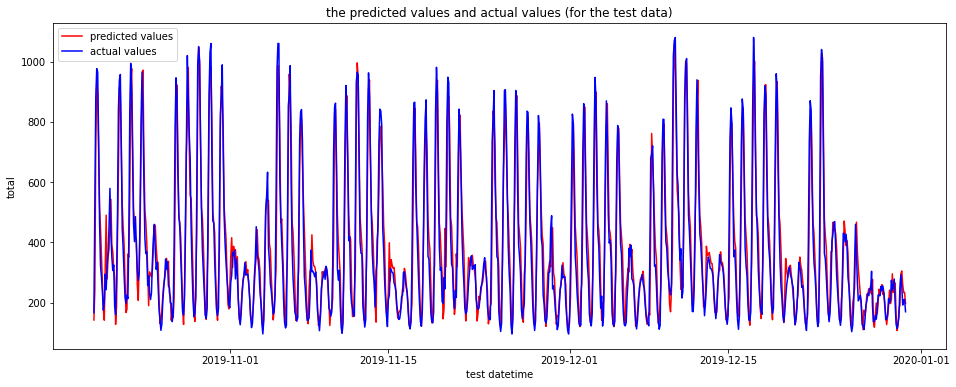

In [16]:
target_name = 'total'
plot_predict_actual_values(test_date,
                           y_pred=yhat[:-1, 0, 0],
                           y_test=unscale_y_test[:, 0, 0],
                           ylabel=target_name)

Plot actual and prediction values for `AvgRate` KPI.

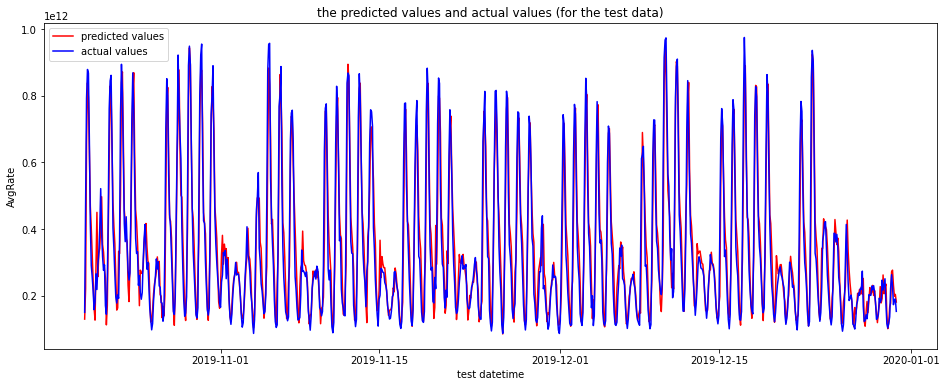

In [15]:
target_name = 'AvgRate'
plot_predict_actual_values(test_date,
                           y_pred=yhat[:-1, 0, 1],
                           y_test=unscale_y_test[:, 0, 1],
                           ylabel=target_name)